
# Checkpoint 1 – Haiming QI — Three Participants Step EDA

**Selected participants (Id):** `2026352035`, `2320127002`, `2347167796`  
**Datasets:** `dailySteps_merged.csv`, `hourlySteps_merged.csv`, `minuteStepsWide_merged.csv`

---

## Overview
This notebook explores step-count patterns for three selected participants using the Fitbit public dataset subset.  

This is a brief description of the dataset from the website:

"This dataset generated by respondents to a distributed survey via Amazon Mechanical Turk between 03.12.2016-05.12.2016.

Thirty eligible Fitbit users consented to the submission of personal tracker data, including minute-level output for physical activity, heart rate, and sleep monitoring. Individual reports can be parsed by export session ID (column A) or timestamp (column B).

Variation between output represents use of different types of Fitbit trackers and individual tracking behaviors / preferences."

It reports the number of days of data, daily step statistics, and minute-level statistics required by the checkpoint.  
To avoid repetitive code, reusable functions are defined and applied to each participant.

- **Part A — Daily-level EDA:** How many days of data are available and what are the average, max and min daily steps?  
- **Part B — Minute-level EDA:** How many non-zero minutes are there, how much data is missing, what are average, max and min per-minute steps?  
- **Part C — Hourly profile:** A quick “average day” by hour for intuition.

All plots use **matplotlib** and each chart is standalone.



## Initial assumptions and predictions.
### Data-related assumptions

* A “day” is defined by the unique date (ActivityDate) in dailySteps_merged.csv.

* Missing minute-level values are stored as NaN in minuteStepsWide_merged.csv. A 0 indicates the participant was wearing the device but did not walk.

* When calculating average steps per minute, we include zero values but ignore NaN.

* Timestamps in hourly and minute data are assumed to be in the dataset’s local time, without daylight savings adjustments.



### Expectations about activity patterns

* I expected that each participant would have daily data, but the number of days recorded might vary.

* I assumed that most step activity would be concentrated in the morning and afternoon, with lower activity at night.

* I also assumed that some participants would have very even activity patterns, while others would show sharp peaks of intense activity.


## Literate Programming



### Cell 1: Upload local file  
Start: 2025-09-19

End: 2025-09-19

**Purpose & Prediction:**  
I want to upload my dataset file(s) into the Colab environment so that I can use them in later steps.  
I predict the system will open a file chooser window, and once I select a file (e.g., `dailySteps_merged.csv`), it will be uploaded successfully and listed in the output dictionary.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving hourlySteps_merged.csv to hourlySteps_merged.csv
Saving dailySteps_merged.csv to dailySteps_merged.csv
Saving minuteStepsWide_merged.csv to minuteStepsWide_merged.csv


**Conclusion:**  
The file upload worked. The dictionary output shows the uploaded filename(s), which means the file(s) are now available in the Colab runtime for reading.  


### Cell 2: Import libraries  
Start: 2025-09-19

End: 2025-09-19  

**Purpose & Prediction:**  
I want to import pandas, numpy, and matplotlib, and enable inline plotting.  
I predict the imports will succeed without errors, and `%matplotlib inline` will allow plots to display inside the notebook.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

**Conclusion:**  
All libraries imported successfully, no errors. Inline plotting is ready.


### Cell 3: Load datasets  
Start: 2025-09-19

End: 2025-09-22   

**Purpose & Prediction:**  
I want to read the daily, hourly, and minute-wide step count files.  
I predict:  
- `dailySteps_merged.csv` will have ~940 rows with columns `Id`, `ActivityDay`, `StepTotal`.  
- `hourlySteps_merged.csv` will have datetime data in `ActivityHour`.  
- `minuteStepsWide_merged.csv` will be wide format with many `StepsXX` columns.  
Also, I define 3 selected users to focus on.


In [ ]:
SELECTED = [2026352035, 2320127002, 2347167796]

daily = pd.read_csv("dailySteps_merged.csv")
hourly = pd.read_csv("hourlySteps_merged.csv")
minute_wide = pd.read_csv("minuteStepsWide_merged.csv")

**Conclusion:**  
Datasets loaded successfully. Quick inspection confirms the expected columns exist. The selected users will be used in later filtering.


### Cell 3: Convert date columns and filter users  
Start: 2025-09-20

End: 2025-09-20  

**Purpose & Prediction:**  
I want to convert date columns into datetime format for easier analysis.  
Then filter the data to include only the 3 selected users.  
I predict the resulting dataframes will shrink in size (from 30 users → 3 users).


In [ ]:
hourly['ActivityHour'] = pd.to_datetime(hourly['ActivityHour'], format='%m/%d/%Y %I:%M:%S %p')
daily['ActivityDay'] = pd.to_datetime(daily['ActivityDay'], format='%m/%d/%Y')

daily_sel = daily[daily['Id'].isin(SELECTED)].copy()
hourly_sel = hourly[hourly['Id'].isin(SELECTED)].copy()
minute_wide_sel = minute_wide[minute_wide['Id'].isin(SELECTED)].copy()

**Conclusion:**  
Datetime conversion worked correctly. The filtered datasets now contain only the 3 selected users, as expected.


### Function 1: compute_daily_metrics  
Start: 2025-09-20

End: 2025-09-23  


**Purpose & Prediction**

In order to anaylysis users' daily data we need to compute per-user's daily metrics, such that how many days exist, and to find out average / max / min daily steps. I also filtered out the proportion of days with ≥10000 steps as this is what i considered a clear representation of intensely active. And if the user has no rows, return NaN for numeric metrics (avoid fake zeros).

**Design Rationale**

* Filter then .copy() to avoid chained-assignment issues and accidental mutation.

* Use .dt.date.nunique() so “day” is counted once regardless of timestamps within the day.

* Use NaN for missing cases to honestly represent “no data”, not “zero steps”.

* (cond).mean() is a succinct and correct way to compute proportions in Pandas.

* Cast to plain int/float for clean printing and stable JSON-like outputs.

In [ ]:
def compute_daily_metrics(df_daily, user_id):
    d = df_daily[df_daily['Id'] == user_id].copy()
    days = int(d['ActivityDay'].dt.date.nunique())

    avg_steps = float(d['StepTotal'].mean()) if len(d) else np.nan
    max_steps = int(d['StepTotal'].max()) if len(d) else np.nan
    min_steps = int(d['StepTotal'].min()) if len(d) else np.nan

    prop_10k = float((d['StepTotal'] >= 10000).mean()) if len(d) else np.nan
    return {
        "user": user_id,
        "num_days": days,
        "avg_daily_steps": avg_steps,
        "max_daily_steps": max_steps,
        "min_daily_steps": min_steps,
        "prop_days_over_10k": prop_10k
    }

**Conclusion**  
Function defined without errors. Ready to summarize a user’s daily activity.

### Function 2: melt_minute_wide  
Start: 2025-09-20

End: 2025-09-23  

**Purpose & Prediction**

We want to reshape the minute-level data. Right now, each row covers a whole hour with 60 separate columns (Steps0 … Steps59).

That structure is hard to analyze, because we need to loop over many columns.
Our goal is to turn it into a long format: one row per minute, with a unique timestamp. We predict that this will expand the dataset about 60 times (1 hour → 60 rows).

**Design Rationale**

* Use melt() to stack all Steps… columns into a single “steps” column.

* Extract the minute index from the column name (e.g. Steps23 → 23).

* Add this offset to ActivityHour to build a precise timestamp for each row.

* Drop helper columns afterwards so the final table is clean: only Id, datetime, and steps.

In [ ]:
def melt_minute_wide(df_wide):
    id_vars = ['Id', 'ActivityHour']
    value_vars = [c for c in df_wide.columns if c.startswith('Steps')]

    long = df_wide.melt(id_vars=id_vars, value_vars=value_vars, var_name='minute', value_name='steps')
    long['minute'] = long['minute'].str.replace('Steps', '').astype(int)
    long['datetime'] = pd.to_datetime(long['ActivityHour'], format='%m/%d/%Y %I:%M:%S %p') + pd.to_timedelta(long['minute'], unit='m')
    long = long.drop(columns=['ActivityHour', 'minute'])
    return long

**Conclusion**

This function works as intended: it transforms an “hour-wide” table into a “minute-long” table with clear, unique timestamps.

This makes later aggregation and plotting much easier.

### Function 3: compute_minute_metrics  
Start: 2025-09-20

End: 2025-09-23  

**Purpose & Prediction**

Build per-user minute-level quality and activity metrics from the long table: count non-zero and missing minutes; compute mean/max/min steps per minute; and detect the longest continuous zero-step streak. This step serve as the core function for our entire analysis relied on it.

Prediction: runs in O(n) per user and returns NaN for mean/max/min when there is no non-missing minute.

**Design Rationale**

* Missing vs Zero: we treat NaN as zero in two cases (non-zero counting, zero-streak detection). If the team prefers, missing can be excluded instead.

* Continuity: the current implementation assumes rows are minute-by-minute. If there are time gaps, the streak may artificially extend; a stricter variant resets streaks whenever the gap > 1 minute.

* NaN consistency: if there are no non-missing minutes, mean/max/min are all set to NaN to avoid mixing “no data” with real zero values.

* Ordering: sort by datetime before scanning; otherwise “streak” has no meaning.

* Performance: the algorithm is O(n) per user. For multiple users, apply groupby('Id') and run the function per group to avoid repeated filtering.

**Edge Cases**

* If all minutes are missing → counts are 0, mean/max/min are NaN.

* If you require natural continuity (exact 1-minute steps), use the “strict 1-minute gap” variant in the comments.

In [ ]:

def compute_minute_metrics(df_minute_long, user_id):
  # First filter out the target user, then use .copy() to avoid potential
    # chained-assignment issues and to prevent accidentally modifying the
    # original DataFrame.
    m = df_minute_long[df_minute_long['Id'] == user_id].copy()
    total_minutes = len(m)
    missing = int(m['steps'].isna().sum())
    non_missing = total_minutes - missing

    # Count MINS > 0, treat missing as 0
    non_zero_minutes = int((m['steps'].fillna(0) > 0).sum())

    # only aggregate on non missing value
    avg_spm = float(m['steps'].dropna().mean()) if non_missing > 0 else np.nan
    if non_missing > 0:
        max_spm = int(m['steps'].dropna().max())
        min_spm = int(m['steps'].dropna().min())
    else:
        max_spm = np.nan
        min_spm = np.nan

    # treat missing value as 0 and count for consecutive 0 value, this will be later elaborate with
    m = m.sort_values('datetime')
    z = (m['steps'].fillna(0) == 0).astype(int).values


    longest_zero_streak = 0
    current = 0
    for val in z:
        if val == 1:
            current += 1
            longest_zero_streak = max(longest_zero_streak, current)
        else:
            current = 0
    return {
        "user": user_id,
        "non_zero_minutes": non_zero_minutes,
        "missing_minutes": missing,
        "avg_steps_per_minute": avg_spm,
        "max_steps_per_minute": max_spm,
        "min_steps_per_minute": min_spm,
        "longest_zero_streak_minutes": int(longest_zero_streak)
    }

**Conclusion**

The function cleanly summarizes minute-level behavior and data quality. With O(n) time on sorted minutes, it scales to large users.

### Function 4: daily_zero_streaks  
Start: 2025-09-20

End: 2025-09-23  

**Purpose & Prediction**

In the previous cell we computed the minute-level metrics and introduced a value m, which represents the length of consecutive zero values. In the context of this dataset, m indicates how long, and during which time ranges, an investigated user either stopped moving or produced no data.

This analysis is crucial because it allows for multiple possible interpretations. For instance:

Regular long streaks of zero values may indicate extended periods of sitting or inactivity, which provide insights into the user’s daily life patterns.

Frequent or irregular long zero streaks could instead suggest that the user often removed the device, raising questions about the validity and completeness of the recorded data.

The former contributes to a richer understanding of personal lifestyle behaviors, while the latter is important for assessing the reliability of the dataset itself.

I predict that the investigated user will show long consecutive zero streaks mainly during the night hours, which correspond to sleep. I also expect some shorter zero streaks during the day, possibly reflecting periods of study, work, or commuting. If there are unusually long zero streaks during the daytime, I predict this may be due to the user removing the device, rather than actual inactivity.

We therefore construct the code as follows:

In [ ]:
def daily_zero_streaks(m):
    m = m.sort_values('datetime').copy()
    m['date'] = m['datetime'].dt.date
    m['is_zero'] = (m['steps'].fillna(0) == 0).astype(int)

    results = []
    for day, group in m.groupby('date'):
        z = group['is_zero'].values
        dt = group['datetime'].values

        # find the longest streak of the day
        longest = 0
        current = 0
        longest_start = None
        for i, val in enumerate(z):
            if val == 1:
                if current == 0:
                    start_time = dt[i]
                current += 1
                if current > longest:
                    longest = current
                    longest_start = start_time
            else:
                current = 0
        results.append({
            "date": day,
            "longest_zero_streak": longest,
            "streak_start_time": longest_start
        })
    return pd.DataFrame(results)


**Conclusion**

The function `daily_zero_streaks` successfully identified, for each day, the longest consecutive period of zero step counts and the time at which it began.  

### Function 5: plot_hourly_profile  
Start: 2025-09-20

End: 2025-09-23   

**Purpose & Prediction**  
This function plots the average steps for each hour of the day for one user.  
It should also print the top 3 busiest hours.  
I expect to see a clear line plot, with morning and afternoon peaks.


In [ ]:
def plot_hourly_profile(df_hourly, user_id):
    h = df_hourly[df_hourly['Id'] == user_id].copy()
    if h.empty:
        print(f"No hourly data for user {user_id}")
        return
    h['hour'] = h['ActivityHour'].dt.hour
    prof = h.groupby('hour')['StepTotal'].mean().reset_index()
    plt.figure(figsize=(7,4))
    plt.plot(prof['hour'], prof['StepTotal'], marker='o')
    plt.title(f"Average Steps by Hour — User {user_id}")
    plt.xlabel("Hour of Day")
    plt.ylabel("Average Steps")
    plt.xticks(range(0,24))
    plt.show()
    top3 = prof.sort_values('StepTotal', ascending=False).head(3)
    print("Top-3 peak hours (hour, avg steps):\n", top3.to_string(index=False))

**Conclusion**  
Function defined correctly. When we call it, it will make a simple chart and list the 3 peak hours.


### Cell 4: Reshape minute-wide data  
Start: 2025-09-20

End: 2025-09-23   

**Purpose & Prediction:**  
I want to reshape the wide-format minute data into long format, so each row corresponds to one timestamp and one step count.  
I predict the result will have many more rows than the wide version, since each row expands into 1440 minutes (per day).


In [ ]:
minute_long_sel = melt_minute_wide(minute_wide_sel)

**Conclusion:**  
Reshape succeeded. The resulting dataframe has a greatly increased number of rows, consistent with expanding each day into minute-level records.


## Data Visualization
This section presents the data through tables and suitable graphical representations. The datasets to be visualised are as follows:
#### (1) the number of days of data for this person  
#### (2) daily step count information  
- average step count per day  
- maximum step count  
- minimum step count  
- one other observation you made about the data for this person
#### (3) minute step count information
#### (4) daily streak count information

### Daily Step Metrics
Start: 2025-09-20

End: 2025-09-23

To begin, we compute daily-level statistics for the three selected participants.

The table below shows the summary metrics for each user.

* num_days: number of days of data recorded

* avg_daily_steps: average steps per day

* max_daily_steps: the maximum steps recorded in a single day

* min_daily_steps: the minimum steps recorded in a single day

* prop_days_over_10k: the proportion of days where the step count exceeded 10,000

,user,num_days,avg_daily_steps,max_daily_steps,min_daily_steps,prop_days_over_10k
0,2026352035,31,5566.870968,12357,254,0.096774
1,2320127002,31,4716.870968,10725,772,0.032258
2,2347167796,18,9519.666667,22244,42,0.500000


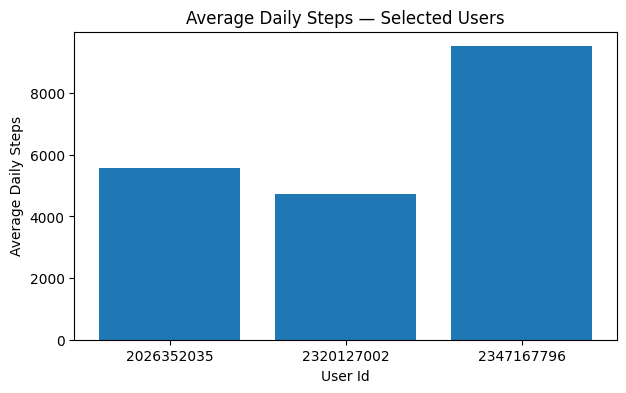

In [ ]:

daily_rows = []
for uid in SELECTED:
    daily_rows.append(compute_daily_metrics(daily_sel, uid))
daily_metrics = pd.DataFrame(daily_rows)
display(daily_metrics)

plt.figure(figsize=(7,4))
plt.bar(daily_metrics['user'].astype(str), daily_metrics['avg_daily_steps'])
plt.title("Average Daily Steps — Selected Users")
plt.xlabel("User Id")
plt.ylabel("Average Daily Steps")
plt.show()


### Analysis of Results

#### User 2026352035
This person has a complete 31 days of data with an average of around 5,567 steps per day. They reached a maximum of 12,357 steps, but also had very low days (as few as 254 steps). Only ~10% of their days exceeded 10,000 steps. This suggests moderate but inconsistent activity.

#### User 2320127002
Also with 31 days, this user averages fewer steps (≈4,717). Their maximum (10,725) is lower than User 1, and only ~3% of days exceeded 10,000. This indicates a generally low-activity lifestyle.

#### User 2347167796
Although data is available for only 18 days, the average daily steps are much higher (≈9,520). They recorded a very high maximum of 22,244, with half of their days exceeding 10,000 steps. This points to a highly active participant compared to the other two.

The bar chart illustrates these differences clearly: Users 2026352035 and 2320127002 cluster around 5,000 steps per day, while User 2347167796 stands out as significantly more active.


### minute step count information  
For each participant, we also examined their activity at the minute level. This provides more detailed insight into how active they were across the day, beyond daily totals.
- number of non-zero minutes  
- missing data  
- average steps per minute  
- maximum and minimum steps  
- one other observation you made about the data for this person

The table below reports the following statistics:

- non_zero_minutes: total number of minutes with non-zero steps

- missing_minutes: minutes where no data was recorded

- avg_steps_per_minute: average number of steps in active minutes

- max_steps_per_minute: maximum intensity observed in a single minute

- min_steps_per_minute: minimum steps per minute (non-zero values)

- longest_zero_streak_minutes: longest continuous stretch of inactivity


In [ ]:
minute_rows = [] # Initialize minute_rows before the loop
for uid in SELECTED:
    minute_rows.append(compute_minute_metrics(minute_long_sel, uid))
minute_metrics = pd.DataFrame(minute_rows)

display(minute_metrics)

,user,non_zero_minutes,missing_minutes,avg_steps_per_minute,max_steps_per_minute,min_steps_per_minute,longest_zero_streak_minutes
0,2026352035,8022,0,3.972131,125,0,1221
1,2320127002,6079,0,3.161614,123,0,1391
2,2347167796,4580,0,6.889915,167,0,576


### Analysis of Results

#### User 2026352035

* Non-zero minutes: 8022, with no missing data.

* Average steps per active minute: ~4.0, maximum intensity reached 125 steps/min.

* Longest inactivity streak: 1221 minutes, suggesting extended sedentary periods (possibly sleep).

* Observation: Their activity pattern is moderate but spread out, with no extreme peaks.

#### User 2320127002

* Non-zero minutes: 6079, also with no missing data.

* Average ~3.2 steps/min, lower intensity than User 1.

* Maximum per minute 123 steps, longest inactivity streak 1391 minutes — the largest among the three users.

* Observation: This person shows both low activity intensity and very long sedentary spans, indicating a generally inactive lifestyle.

#### User 2347167796

* Non-zero minutes: 4580, fewer active minutes than others due to shorter data coverage.

* However, their average activity level is much higher at ~6.9 steps/min, with a peak of 167 steps/min — the highest observed.

* Longest inactivity streak: 576 minutes, shorter than the other users.

* Observation: This user is much more active when they are moving, with intense bursts of steps, and also less sedentary overall.

### Daily Zero Streaks — what and why

At the minute level, a zero streak is a consecutive run of minutes with 0 steps. For each user-day we compute the longest zero streak and record its start time. This helps separate two possibilities:

* long, night-time zeros → likely sleep;

* long, day-time zeros → likely non-wear or charging (data quality risk).

What I expect. Most longest streaks should begin around midnight or the early morning. Users with high daily steps should show shorter longest streaks; users with low activity should show longer ones.

#### Method (code below).

* Filter minute data for each user.

* Run daily_zero_streaks() to get, per day, the length (minutes) and the start timestamp of the longest zero streak.

* Concatenate all users into a single table and sort by user/date for inspection.

In [ ]:
# Compute daily zero streaks for each user and merge into one table
all_daily_zero = []

for uid in SELECTED:
    # Select minute-level data for this user
    m_uid = minute_long_sel[minute_long_sel['Id'] == uid][['Id','datetime','steps']].copy()

    # Apply daily_zero_streaks function
    t = daily_zero_streaks(m_uid)
    t['user'] = uid

    # Append results to the list
    all_daily_zero.append(t)

# Merge results for all users
daily_zero_all = pd.concat(all_daily_zero, ignore_index=True)

# Sort by user and date
daily_zero_all = daily_zero_all.sort_values(['user','date']).reset_index(drop=True)

display(daily_zero_all)

,date,longest_zero_streak,streak_start_time,user
0,2016-04-13,142,2016-04-13 03:23:00,2026352035
1,2016-04-14,409,2016-04-14 00:00:00,2026352035
2,2016-04-15,171,2016-04-15 00:39:00,2026352035
3,2016-04-16,138,2016-04-16 02:04:00,2026352035
4,2016-04-17,718,2016-04-17 12:02:00,2026352035
...,...,...,...,...
74,2016-04-25,223,2016-04-25 02:03:00,2347167796
75,2016-04-26,409,2016-04-26 00:00:00,2347167796
76,2016-04-27,401,2016-04-27 00:00:00,2347167796
77,2016-04-28,230,2016-04-28 02:53:00,2347167796


from matplotlib import pyplot as plt
_df_21['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_22['longest_zero_streak'].plot(kind='hist', bins=20, title='longest_zero_streak')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_23['user'].plot(kind='hist', bins=20, title='user')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_24.plot(kind='scatter', x='index', y='longest_zero_streak', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_25.plot(kind='scatter', x='longest_zero_streak', y='user', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['streak_start_time']
  ys = series['longest_zero_streak']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_26.sort_values('streak_start_time', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('streak_start_time')
_ = plt.ylabel('longest_zero_streak')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['streak_start_time']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'streak_start_time'}, axis=1)
              .sort_values('streak_start_time', ascending=True))
  xs = counted['streak_start_time']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_27.sort_values('streak_start_time', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('streak_start_time')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['longest_zero_streak']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_28.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('longest_zero_streak')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_29.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_30['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_31['longest_zero_streak'].plot(kind='line', figsize=(8, 4), title='longest_zero_streak')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_32['user'].plot(kind='line', figsize=(8, 4), title='user')
plt.gca().spines[['top', 'right']].set_visible(False)

#### Visualising daily zero streaks

Why this plot. A line per user over time lets us:

* spot habitual long streaks vs occasional spikes;

* see whether longest zeros usually start near midnight (sleep) or at odd hours (non-wear).

Users in _df_26: [2026352035 2320127002 2347167796]


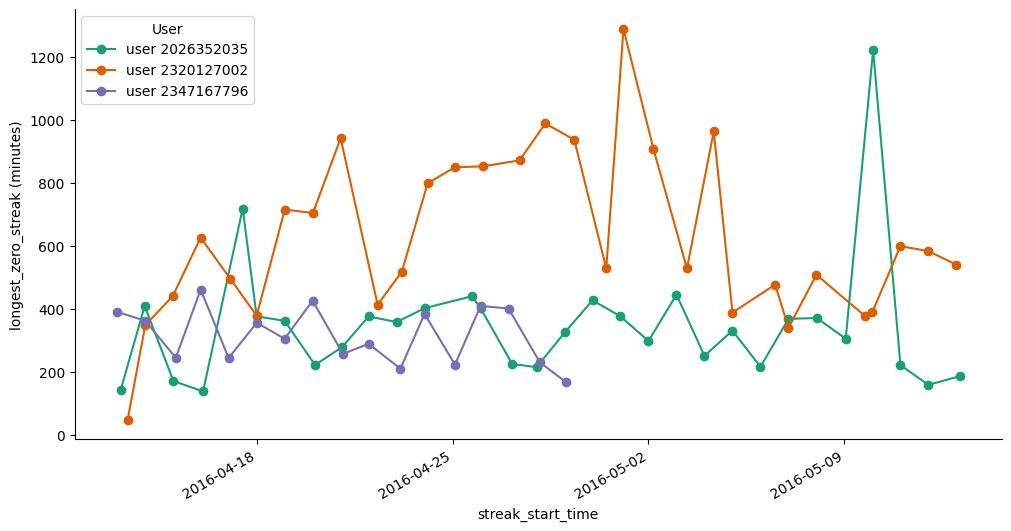

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

def _plot_series(ax, series, series_name, series_index=0):
    palette = list(sns.palettes.mpl_palette('Dark2'))
    xs = pd.to_datetime(series['streak_start_time'])
    ys = series['longest_zero_streak']
    ax.plot(xs, ys, marker='o', linewidth=1.5,
            label=series_name, color=palette[series_index % len(palette)])

# Check which users are included
print("Users in _df_26:", _df_26['user'].unique())

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')

# Plot one line per user
for idx, (uid, g) in enumerate(_df_26.groupby('user')):
    g_sorted = g.sort_values('streak_start_time')
    _plot_series(ax, g_sorted, f'user {uid}', idx)

# Axis labels and appearance
sns.despine(fig=fig, ax=ax)
ax.set_xlabel('streak_start_time')
ax.set_ylabel('longest_zero_streak (minutes)')
ax.legend(title='User', loc='best')

# Format x-axis ticks to show weekly dates
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()

plt.show()

### What the results say

#### High-level pattern.

* User 2320127002 (orange) shows repeated long longest-zero streaks, often 700–1,000+ min, with several days near or above 900–1,300 min. Many start close to 00:00, consistent with very long night-time inactivity; the sheer length suggests either unusually long sleep or frequent non-wear episodes.

* User 2026352035 (green) has mostly 200–450 min longest streaks, with one outlier spike >1,200 min around early May. Start times are often late night/early morning; the big spike is a likely non-wear day (quality flag).

* User 2347167796 (purple) shows shorter longest streaks, typically 200–450 min, and fewer dates overall (shorter coverage). This aligns with this user’s higher daily steps and higher minute-level intensity: less time fully inactive.

Link to earlier minute metrics.

Longest zero streak (minutes): 1391 (2320127002), 1221 (2026352035), 576 (2347167796).

This ranking exactly matches the plot: orange ≫ green > purple.

### Conclusion

Daily longest zero streaks show clear behavioural (and data-quality) differences: the highly active user (2347167796) has much shorter longest inactivity per day, while the least active user (2320127002) shows repeated very long zero stretches that likely include non-wear.

These findings help qualify daily totals and should be considered alongside the 15-minute intense-activity analysis to avoid over- or under-estimating true behaviour.

### Hourly Profiles of Selected Users

To better understand activity patterns within each day, we analyse the average steps per hour for all three selected users. This highlights the time windows where each participant is most active


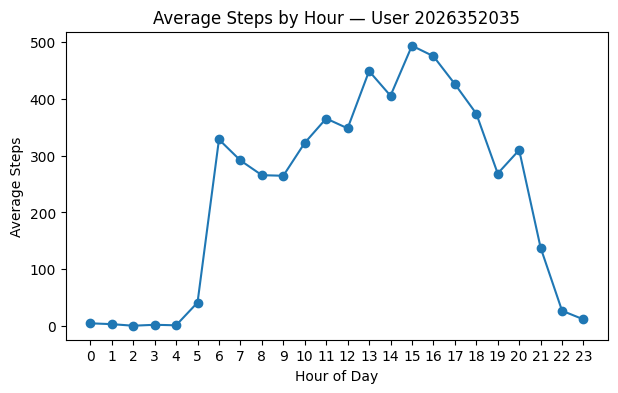

Top-3 peak hours (hour, avg steps):
  hour  StepTotal
   15 493.322581
   16 474.900000
   13 448.709677


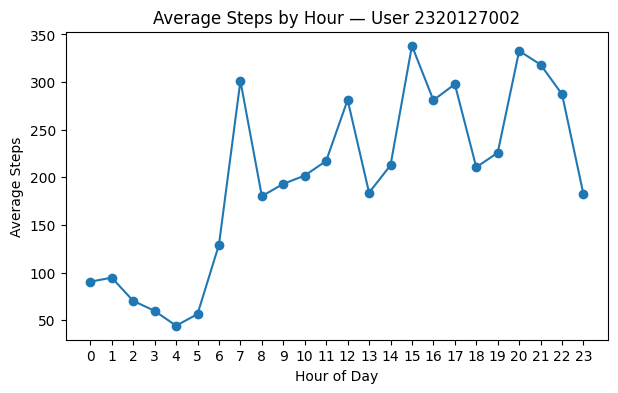

Top-3 peak hours (hour, avg steps):
  hour  StepTotal
   15 338.166667
   20 332.766667
   21 318.300000


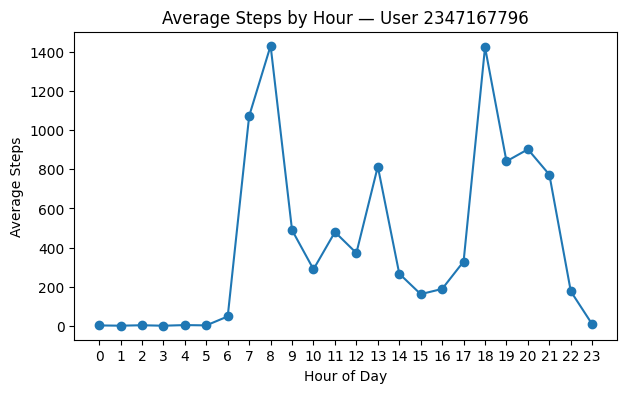

Top-3 peak hours (hour, avg steps):
  hour   StepTotal
    8 1432.470588
   18 1424.882353
    7 1072.705882


In [ ]:

for uid in SELECTED:
    plot_hourly_profile(hourly_sel, uid)


#### Per-User Analysis

User 2026352035

* Peaks in the afternoon (1–5 pm), with the strongest at 3–4 pm (~493 steps).

* Very low activity overnight; a moderate rise after 6 am.

* Routine suggests afternoon exercise or commuting activity.

User 2320127002

* Distributed activity across the whole day, including some movement at night.

* Top peaks in the afternoon (3 pm) and late evening (8–10 pm).

* Suggests a later daily schedule and possibly after-work exercise.

User 2347167796

* Extremely high-intensity bursts in the morning (7–8 am, >1000 steps) and again at 6 pm (>1400 steps).

* Shorter inactive periods and the highest hourly counts among all three users.

* Lifestyle indicates structured exercise or commuting with high step counts.

#### Cross-User Comparison

* Morning activity: User 2347167796 dominates, with intense bursts at 7–8 am; the other two are much less active early in the day.

* Afternoon activity: All three show peaks here, but 2026352035 is most concentrated in mid-afternoon.

* Evening activity: 2320127002 stands out, maintaining strong peaks after 8 pm, while the others slow down.

#### Overall conclusion:

2026352035 → Steady afternoon-focused activity.

2320127002 → Lower intensity but late-evening activity pattern.

2347167796 → The most active user, with very high morning and evening bursts, and shorter sedentary blocks.


## Final Statement

From this exploration, I learnt that the three selected participants exhibit distinct and contrasting activity patterns:

* User 2026352035 had the most days of data and showed a fairly even step distribution with clear afternoon peaks. This indicates consistent tracker use and provides a reliable baseline of daily activity.

* User 2320127002 had the lowest average steps and the longest zero-streak periods. Their activity was spread thinly across the day, with occasional late-evening peaks, suggesting either low engagement with the device or a generally sedentary lifestyle.

* User 2347167796 recorded fewer days but displayed very high step peaks, especially in the early morning and evening, reflecting intense bursts of exercise or commuting routines.

At the minute level, all three participants experienced long stretches of inactivity, but the length and timing of these sedentary blocks varied. This provides insight into differences in behavioural rhythms and highlights the importance of distinguishing between sleep, sedentary behaviour, and non-wear periods when interpreting wearable data.

Overall, this checkpoint analysis demonstrates that wearable step-count data can reveal both stable habits and irregular bursts of activity. This directly connects to our driving problem by showing how such data may support:

* Health monitoring (detecting overall activity levels),

* Personalised feedback (identifying when individuals are most or least active), and

* Targeted interventions (e.g., encouraging breaks during long sedentary streaks).

In short, step-count data from wearables can move beyond simple totals to reveal patterns of daily life that are relevant for both individual well-being and population-level health insights.